## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [13]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [14]:
#Reading in dataset and looking at the top 5 lines.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [15]:
#Using the .shape to see the number of rows.
df.shape[0]

294478

c. The number of unique users in the dataset.

In [16]:
#Using .nunique() to see the number of unique users.  This number differs
#from the shape of the dataframe meaning some users have visited more than
#once.
df.user_id.nunique()

290584

d. The proportion of users converted.

In [17]:
#It appears that 11.96% of users who visited the site have converted.
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [18]:
#Grouping by 'group' and 'landing page' shows the number of times 
#each page was shown to each group.
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

f. Do any of the rows have missing values?

In [19]:
#Checking for null values using .info(). It appears there aren't any 
#null values so we do not need to do this type of cleaning.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [20]:
#Defining variables as the control group should have received only the
#old page and the treatment group only the new page.
df_c = df.query('group == "control" & landing_page == "old_page"')
df_t = df.query('group == "treatment" & landing_page == "new_page"')

#Appending the two so that the new dataframe has only the correct pages
#per group.  Then looking at the .shape to see if it corraborates the 
#numbers in Part I e.
df2 = df_c.append(df_t)
df2.shape[0]

290585

In [21]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [22]:
#Checking for the uniquer user ids we see that it is closer to the shape
#of the dataframe.
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [23]:
#By doing a groupby on 'user_id' and querying if the count of group was 
#greater than 1 shows the user who has been listed more than once.
df2.groupby('user_id').count().query('group >1')

,timestamp,group,landing_page,converted
user_id,,,,
773192,2,2,2,2


c. What is the row information for the repeat **user_id**? 

In [24]:
#Using a query shows the two rows where this user has been captured in our
#data.
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [25]:
#Both listings show that the user was in the treatment group, received the
#correct page and did not convert.  Therefore it doesn't matter which page
#we drop.

df2 = df2.drop(index = 2893)
df2.shape[0]

290584

In [26]:
#For consistency reasons, I removed the one same line the df_t 
#dataframe as well in case this dataframe is needed in the future.
df_t.query('user_id == 773192')
df_t = df_t.drop(index = 2893)
df_t.shape[0]


145310

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [27]:
#As page is irrelevant in this question we can look solely at the 
#'converted' column.
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [28]:
#Querying for control shows a mean of 12%.
ctl = df2.query('group == "control"')
ctl.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [29]:
#Querying for treatment shows a mean of 11.88%.
tre = df2.query('group == "treatment"')
tre.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [30]:
#Finding probabilty that an individual received the new page.
df2.query('group =="treatment"').shape[0]/df2.shape[0]

0.5000619442226688

In [31]:
#The current difference in mean is -.0015
diff = tre.converted.mean() - ctl.converted.mean()
diff

-0.0015782389853555567

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

##### Thus far I have looked at descriptive statistics only.  To understand the population parameters it is necessary to perform A/B testing. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null: P(old) - P(new) >= 0

Alternative: P(old) - P(new) < 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [32]:
#Assuming that both p_new and p_old are equal and are equal to the
#converted rate in ab_dataset. The converted rate was the conversion rate 
#regardless of what page was served to the groups.

p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [33]:
#Assuming that both p_new and p_old are equal and are equal to the
#converted rate in ab_dataset. The converted rate was the conversion rate 
#regardless of what page was served to the groups.

p_old = df2.converted.mean()
p_old

0.11959708724499628

In [34]:
#As the two are equal, the difference is 0.

p_new - p_old


0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [35]:
#Per instruction, using the same number of pages that were used in the
#ab_dataset, the new pages would be equal to the treatment group.

n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [36]:
#Per instruction, using the same number of pages that were used in the
#ab_dataset, the old pages would be equal to the control group.

n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
#Running a binomial simulation to try and find the probability of conversion
#or no converstion.  Used 1 as the first argument as we want only 0 or 1 to be returned, p_new as
#that is the current probably and n_new as that is the count of pages.
#The answer creates a similar mean as the original dataset as the 
#numbers are the same. However, as it is a simulation, the output can change.

new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.12007432385933521

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [38]:
#Similar idea as above but looking at the control group and old pages.

old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11963599818274433

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [39]:
#This makes sense as the p_new and p_old were equal and so the simulation
#resulted in a near equal mean.

new_page_converted.mean() - old_page_converted.mean()

0.00043832567659088384

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [40]:
#Running a simulation using 10,000 values, once again through the binomial
#distribution. We are have to get the proportion as otherwise the output
#would be a large number as it represents the page count. Using this 

new_conv_sim = np.random.binomial(n_new, p_new, 10000)/n_new
old_conv_sim = np.random.binomial (n_old, p_old, 10000)/n_old

p_diffs = new_conv_sim - old_conv_sim
p_diffs

array([  7.27530034e-04,   2.35842351e-03,  -2.35850660e-04, ...,
         8.99576004e-04,  -3.65570153e-05,  -9.51955839e-04])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

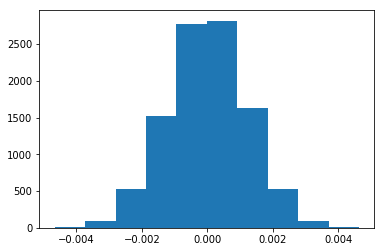

In [41]:
#Using the sampling distribution from above, we get the following.
plt.hist(p_diffs);


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [42]:
obs_diffs = tre.converted.mean() - ctl.converted.mean()
p_diffs.mean() - obs_diffs

0.0015823843043512311

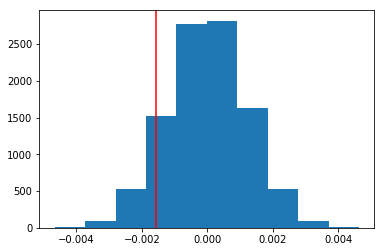

In [43]:
#Sample distribution of p_diffs with the red line showing the obs_diffs
#from the observed.  This matches with the above as we see that the obs_diff
#is negative by .0015.

plt.hist(p_diffs);
plt.axvline(obs_diffs, color = "r")

In [44]:
#The p-value can be found with the following equation.

(p_diffs > obs_diffs).mean()

0.89980000000000004

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The p-value is .90 which is far greater than our alpha of 0.05 and also near 1.  This means we fail to reject the null hypothesis. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [45]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old
n_new
convert_old, convert_new, n_old, n_new 

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [46]:
#alternative of smaller because p1>0
count = [convert_old, convert_new]
nobs = [n_old, n_new]
z_score, p_value = sm.stats.proportions_ztest(count, nobs , alternative = "smaller")
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score is the number of standard deviations away from the mean. The p-value states the probability that the values are within the null values.  The p-value from the stats test match with that from the binomial distribution example as one would expect. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

This would be a logistic regression as we are trying to predict only two options and so it is bounded by a 0 and 1.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [47]:
#Creating an intercept to us in as one of the x-variables plus creating
#dummy variables to replace the categorical variables.

df2['intercept'] = 1
df2[['ab_treatment', 'new_page']] = pd.get_dummies(df['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_treatment,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1


In [48]:
#Creating a dataframe with only relevant data for a logistic regression 
#model.  So dropping 'timestamp', 'group', 'landing_page' and
#the new_page dummy variable. Keeping user_id to use for a merge later in
#the notebook.

df2 = df2[['user_id','converted', 'intercept', 'ab_treatment']]
df2.head()

,user_id,converted,intercept,ab_treatment
0,851104,0,1,0
1,804228,0,1,0
4,864975,1,1,0
5,936923,0,1,0
7,719014,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [49]:
#Iniating and fitting a logistic regression model.  Outputting a summary
#to understand the values and fit.

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_treatment']])
model = log_mod.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:24:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_treatment    -0.0150      0.011     -1.311      0.190      -0.037       0.007
================================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


The p-value found in the logistic regression is .19.  This differs from the above as it is a two-side tail with the nul hypothesis being P_old = 0.  To receive a similar p-value as to the above, we would need to divide this by 2, to make it a two-sided tail, and then subtract from 1.  This would give us .90. 

The p-value of .190 is higher than the alpha of .05 means the relationship of the term and response is insignificant.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It is good to consider multiple variables because there is the possibility that more than one variable has an influence on the response.  For instance, in the house example given in the studies, the price is a response to area of the house AND neighbourhood.

Problems can arise when looking at more than one variable including such issues as outliers and multi-collinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [50]:
#Reading the country document and looking at the head.

countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
#Merging the two databases on user_id.

df_new = df2.merge(countries_df, on = 'user_id')
df_new.head()

,user_id,converted,intercept,ab_treatment,country
0,851104,0,1,0,US
1,804228,0,1,0,US
2,864975,1,1,0,US
3,936923,0,1,0,US
4,719014,0,1,0,US


In [52]:
#Looking at the unique country values.

df_new.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [53]:
#Creating the dummy variables.
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,user_id,converted,intercept,ab_treatment,country,CA,UK,US
0,851104,0,1,0,US,0,0,1
1,804228,0,1,0,US,0,0,1
2,864975,1,1,0,US,0,0,1
3,936923,0,1,0,US,0,0,1
4,719014,0,1,0,US,0,0,1


In [54]:
#Dropping one of the variables as it is redundant.
df_new = df_new.drop(['country', 'US'], axis = 1)
df_new.head()

,user_id,converted,intercept,ab_treatment,CA,UK
0,851104,0,1,0,0,0
1,804228,0,1,0,0,0
2,864975,1,1,0,0,0
3,936923,0,1,0,0,0
4,719014,0,1,0,0,0


In [55]:
#Iniating and fitting a logistic regression model.  Outputting a summary
#to understand the values and fit.

log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_treatment', 'CA', 'UK']])
model2 = log_mod2.fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        11:25:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_treatment    -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA              -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK               0.0099      0.013      0.743      0.457      -0.016       0.036
================================================================================
"""

In [63]:
#Calculating the exponential so that we can interpret.
CA_exp = np.exp(-0.0408)
1/CA_exp

1.0416437559600236

In [64]:
#Calculating the exponential so that we can interpret.
UK_coef = np.exp(-0.0099)
1/UK_coef

1.009949167117542

We can read the above that all the variables are insignificant due to the p-values being above the alpha of .05. Also individuals based in the US are more likely to convert.  In comparison to Canada, Americans are more likely to convert 1.04x as often holding all other things constant. And they are 1x more likely to convert than an individual based in the UK, holding all other variables constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [65]:
#Creating interaction variables by multiplying the treatment and the 
#country together.
df_new['page_uk'] = df_new['ab_treatment'] * df_new['UK']
df_new.head()

,user_id,converted,intercept,ab_treatment,CA,UK,page_ca,page_uk
0,851104,0,1,0,0,0,0,0
1,804228,0,1,0,0,0,0,0
2,864975,1,1,0,0,0,0,0
3,936923,0,1,0,0,0,0,0
4,719014,0,1,0,0,0,0,0


In [66]:
#Iniating and fitting a logistic regression model.  Outputting a summary
#to understand the values and fit.

log_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_treatment', 'CA', 'UK', 'page_ca', 'page_uk']])
model3 = log_mod3.fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 29 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        11:42:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_treatment    -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA              -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK              -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_ca         -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_uk          0.0314      0.027      1.181      0.238      -0.021       0.084
================================================================================
"""

By adding in the higher order terms, we can assess if a variable is dependent on another. In this case, I do not see any added value to adding these calculations into the model.

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0